In [1]:
from PIL import Image
import tifffile as tiff
import matplotlib.pyplot as plt
from glob import glob
import os
import random

import pandas as pd
import numpy as np
from tqdm import tqdm

import tensorflow as tf



2024-11-21 14:53:59.474491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 14:53:59.499741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 14:53:59.507412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 14:53:59.529445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 14:54:08.028652: W tensorflow/compiler/tf2

In [2]:
# check if gpu is available
tf.test.is_built_with_cuda()


True

### Download the breast cancer cell segmentation dataset


In [3]:
!git clone https://huggingface.co/datasets/myatmo/breast_cancer_cell


Cloning into 'breast_cancer_cell'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 214 (delta 143), reused 0 (delta 0), pack-reused 4 (from 1)
Receiving objects: 100% (214/214), 198.19 KiB | 2.87 MiB/s, done.
Resolving deltas: 100% (143/143), done.
Updating files: 100% (203/203), done.


In [4]:
# make sure the dataset is saved on your working directory

!ls breast_cancer_cell/breast_cancer/

Images	Masks


### Data Preprocessing

#### Load dataset from folder

In [8]:
data_dir = "breast_cancer_cell/breast_cancer/"
image_dir = os.path.join(data_dir, "Images")
mask_dir = os.path.join(data_dir, "Masks")

image_path = glob(os.path.join(image_dir, "*.tif"))
#masks = glob(os.path.join(masks_path, "*.TIF"))

# only load the masks that match the names in images
mask_path = [os.path.join(mask_dir, i.rsplit("/",1)[-1].split("_ccd")[0]+".TIF") for i in image_path]




In [9]:
print("Number of Images: ", len(image_path))
print("Number of Masks: ", len(mask_path))
print("First image path: ", image_path[0])
print("First mask path: ", mask_path[0])


Number of Images:  50
Number of Masks:  50
First image path:  breast_cancer_cell/breast_cancer/Images/ytma10_010704_benign1_ccd.tif
First mask path:  breast_cancer_cell/breast_cancer/Masks/ytma10_010704_benign1.TIF


In [11]:
# load the first image and mask using tifffile
img1 = tiff.imread(image_path[0]) / 255.0 # normalize the image pixel to [0, 1]
mask1 = tiff.imread(mask_path[0]) / 255.0


print("Image 1 shape: ", img1.shape)
print("Mask 1 shape: ", mask1.shape)

print("Image 1 range: ", np.min(img1), np.max(img1))
print("Mask 1 range: ", np.min(mask1), np.max(mask1))


TiffFileError: not a TIFF file b'vers'

#### Visualize the first image and mask pair

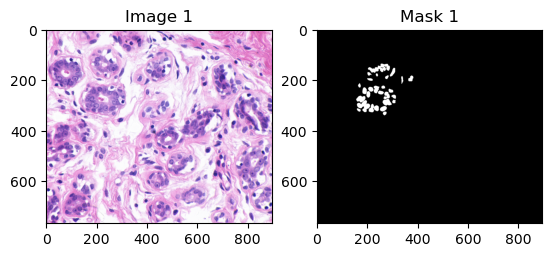

In [7]:
def visualize_image_pair(image, mask):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Image 1")
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Mask 1")
    fig.show()

    
visualize_image_pair(img1, mask1)

### Load data to Pandas Dataframe and Split dataset

In [8]:
# Create dataframe with 2 columns: images and masks
df = pd.DataFrame({'images': image_path,
                   'masks': mask_path})
                  
df.head()


,images,masks
0,datasets/breast_cancer/Images/ytma10_010704_be...,datasets/breast_cancer/Masks/ytma10_010704_ben...
1,datasets/breast_cancer/Images/ytma10_010704_be...,datasets/breast_cancer/Masks/ytma10_010704_ben...
2,datasets/breast_cancer/Images/ytma10_010704_be...,datasets/breast_cancer/Masks/ytma10_010704_ben...
3,datasets/breast_cancer/Images/ytma10_010704_ma...,datasets/breast_cancer/Masks/ytma10_010704_mal...
4,datasets/breast_cancer/Images/ytma10_010704_ma...,datasets/breast_cancer/Masks/ytma10_010704_mal...


In [9]:
# Split data into training and test sets; mostly 70/15/15 ratio
train_split = int(0.7 * len(df))

val_split = int(0.15 * len(df))

train_df = df[0 : train_split]

val_df = df[train_split : train_split+val_split]

test_df = df[train_split+val_split : ]



In [10]:
train_df.tail()

,images,masks
35,datasets/breast_cancer/Images/ytma49_042403_ma...,datasets/breast_cancer/Masks/ytma49_042403_mal...
36,datasets/breast_cancer/Images/ytma49_072303_be...,datasets/breast_cancer/Masks/ytma49_072303_ben...
37,datasets/breast_cancer/Images/ytma49_072303_be...,datasets/breast_cancer/Masks/ytma49_072303_ben...
38,datasets/breast_cancer/Images/ytma49_072303_ma...,datasets/breast_cancer/Masks/ytma49_072303_mal...
39,datasets/breast_cancer/Images/ytma49_072303_ma...,datasets/breast_cancer/Masks/ytma49_072303_mal...


In [11]:
val_df

,images,masks
40,datasets/breast_cancer/Images/ytma49_111003_be...,datasets/breast_cancer/Masks/ytma49_111003_ben...
41,datasets/breast_cancer/Images/ytma49_111003_be...,datasets/breast_cancer/Masks/ytma49_111003_ben...
42,datasets/breast_cancer/Images/ytma49_111003_be...,datasets/breast_cancer/Masks/ytma49_111003_ben...
43,datasets/breast_cancer/Images/ytma49_111003_ma...,datasets/breast_cancer/Masks/ytma49_111003_mal...
44,datasets/breast_cancer/Images/ytma49_111003_ma...,datasets/breast_cancer/Masks/ytma49_111003_mal...
45,datasets/breast_cancer/Images/ytma49_111003_ma...,datasets/breast_cancer/Masks/ytma49_111003_mal...
46,datasets/breast_cancer/Images/ytma49_111303_be...,datasets/breast_cancer/Masks/ytma49_111303_ben...
47,datasets/breast_cancer/Images/ytma49_111303_be...,datasets/breast_cancer/Masks/ytma49_111303_ben...


In [12]:
test_df

,images,masks
48,datasets/breast_cancer/Images/ytma49_111303_be...,datasets/breast_cancer/Masks/ytma49_111303_ben...
49,datasets/breast_cancer/Images/ytma49_111303_ma...,datasets/breast_cancer/Masks/ytma49_111303_mal...
50,datasets/breast_cancer/Images/ytma49_111303_ma...,datasets/breast_cancer/Masks/ytma49_111303_mal...
51,datasets/breast_cancer/Images/ytma49_111303_ma...,datasets/breast_cancer/Masks/ytma49_111303_mal...
52,datasets/breast_cancer/Images/ytma55_030603_be...,datasets/breast_cancer/Masks/ytma55_030603_ben...
53,datasets/breast_cancer/Images/ytma55_030603_be...,datasets/breast_cancer/Masks/ytma55_030603_ben...
54,datasets/breast_cancer/Images/ytma55_030603_be...,datasets/breast_cancer/Masks/ytma55_030603_ben...
55,datasets/breast_cancer/Images/ytma55_030603_be...,datasets/breast_cancer/Masks/ytma55_030603_ben...
56,datasets/breast_cancer/Images/ytma55_030603_be...,datasets/breast_cancer/Masks/ytma55_030603_ben...
57,datasets/breast_cancer/Images/ytma55_030603_be...,datasets/breast_cancer/Masks/ytma55_030603_ben...


In [13]:
test_df['images'][48], test_df['masks'][48]

('datasets/breast_cancer/Images/ytma49_111303_benign3_ccd.tif',
 'datasets/breast_cancer/Masks/ytma49_111303_benign3.TIF')

In [14]:
# Fix the indexing; make the index starts from 0
val_df = val_df.reset_index(drop=True)

val_df.head()

,images,masks
0,datasets/breast_cancer/Images/ytma49_111003_be...,datasets/breast_cancer/Masks/ytma49_111003_ben...
1,datasets/breast_cancer/Images/ytma49_111003_be...,datasets/breast_cancer/Masks/ytma49_111003_ben...
2,datasets/breast_cancer/Images/ytma49_111003_be...,datasets/breast_cancer/Masks/ytma49_111003_ben...
3,datasets/breast_cancer/Images/ytma49_111003_ma...,datasets/breast_cancer/Masks/ytma49_111003_mal...
4,datasets/breast_cancer/Images/ytma49_111003_ma...,datasets/breast_cancer/Masks/ytma49_111003_mal...


In [15]:
test_df = test_df.reset_index(drop=True)

test_df.head()

,images,masks
0,datasets/breast_cancer/Images/ytma49_111303_be...,datasets/breast_cancer/Masks/ytma49_111303_ben...
1,datasets/breast_cancer/Images/ytma49_111303_ma...,datasets/breast_cancer/Masks/ytma49_111303_mal...
2,datasets/breast_cancer/Images/ytma49_111303_ma...,datasets/breast_cancer/Masks/ytma49_111303_mal...
3,datasets/breast_cancer/Images/ytma49_111303_ma...,datasets/breast_cancer/Masks/ytma49_111303_mal...
4,datasets/breast_cancer/Images/ytma55_030603_be...,datasets/breast_cancer/Masks/ytma55_030603_ben...


In [16]:
val_df['images'][0]

'datasets/breast_cancer/Images/ytma49_111003_benign1_ccd.tif'

In [17]:
test_df['images'][0]

'datasets/breast_cancer/Images/ytma49_111303_benign3_ccd.tif'

### Create datagenerator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Custom generator to load and augment images and masks
# And apply data augmentation: define rotation angle, width and height shift, shear and zoom range, horizontal flip

def get_data_generator(df, batch_size=3, target_size=(512,512)):
    image_datagen = ImageDataGenerator(
                rescale=1.0 / 255.0,       # Normalize images to [0, 1]
                fill_mode="nearest",       # Fill pixels after augmentation
                rotation_range=0.01,         # Randomly rotate images
                width_shift_range=0.01,     # Randomly shift images horizontally
                height_shift_range=0.01,    # Randomly shift images vertically
                horizontal_flip=True,      # Randomly flip images horizontally
                )


    mask_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


    image_generator = image_datagen.flow_from_dataframe(
                    dataframe=df,
                    x_col="images",  # Column name for image paths
                    class_mode=None, # No labels, we are handling segmentation
                    target_size=target_size,  # Resize images
                    color_mode="grayscale",  # Use grayscale images
                    batch_size=batch_size,
                    seed=42
                    )

    # Load masks
    mask_generator = mask_datagen.flow_from_dataframe(
                    dataframe=df,
                    x_col="masks",
                    class_mode=None,
                    target_size=target_size,
                    color_mode="grayscale",
                    batch_size=batch_size,
                    seed=42
                    )

    for img, mask in zip(image_generator, mask_generator):
        yield img, mask


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Get test generator
def get_test_generator(df, batch_size=3, target_size=(512,512)):
    image_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    mask_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    image_generator = image_datagen.flow_from_dataframe(
                    dataframe=df,
                    x_col="images",  # Column name for image paths
                    class_mode=None, # No labels, we are handling segmentation
                    target_size=target_size,  # Resize images
                    color_mode="grayscale",  # Use grayscale images
                    batch_size=batch_size,
                    seed=42
                    )

    # Load masks
    mask_generator = mask_datagen.flow_from_dataframe(
                    dataframe=df,
                    x_col="masks",
                    class_mode=None,
                    target_size=target_size,
                    color_mode="grayscale",
                    batch_size=batch_size,
                    seed=42
                    )

    for img, mask in zip(image_generator, mask_generator):
        yield (img, mask)



In [20]:
# Create 3 generators for train, val and test sests
train_generator = get_data_generator(train_df)
val_generator = get_data_generator(val_df)

test_generator = get_test_generator(test_df)


In [21]:
# Testing the shapes of image mask pairs in data generator
batch_x, batch_y = next(train_generator)

# Check shapes
print("Input shape:", batch_x.shape)
print("Output shape:", batch_y.shape)


Found 40 validated image filenames.
Found 40 validated image filenames.
Input shape: (3, 512, 512, 1)
Output shape: (3, 512, 512, 1)


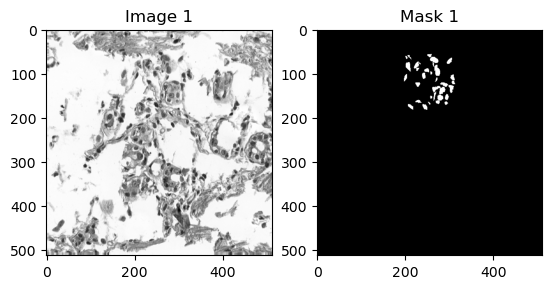

In [22]:
visualize_image_pair(batch_x[0], batch_y[0])

### UNet

In [28]:
# Build UNet architecture
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.models as models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate


def unet(input_shape=(512,512,1), n_filters=16, n_classes=1):
    inputs = Input(input_shape)

    # Encoder
    # Block 1
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    conv2 = Conv2D(n_filters*2, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters*2, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3
    conv3 = Conv2D(n_filters*4, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters*4, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4
    conv4 = Conv2D(n_filters*8, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(n_filters*8, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = Conv2D(n_filters*16, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(n_filters*16, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    # Block 6
    up6 = Conv2DTranspose(n_filters*8, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(n_filters*8, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(n_filters*8, 3, activation='relu', padding='same')(conv6)

    # Block 7
    up7 = Conv2DTranspose(n_filters*4, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(n_filters*4, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(n_filters*4, 3, activation='relu', padding='same')(conv7)

    # Block 8
    up8 = Conv2DTranspose(n_filters*2, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(n_filters*2, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(n_filters*2, 3, activation='relu', padding='same')(conv8)

    # Block 9
    up9 = Conv2DTranspose(n_filters, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(n_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model


### Train the model with generators

In [23]:
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.optimizers as optimizers

batch_size=3
epochs = 300
optimizer = 'adam'
loss='binary_crossentropy'
metrics = 'accuracy'
file_path = "trained_model/best_unet_model.keras"


def train_model():
    model = unet()
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

    steps_per_epoch = len(train_df) // batch_size
    validation_steps = len(val_df) // batch_size

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor = 'val_loss',         # Monitor validation loss
        patience = 25,                # Number of epochs to wait without improvement
        restore_best_weights = True   # Restore weights from the epoch with the best validation loss
    )
    
    # Define checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        filepath = file_path,  # Save the best model
        monitor = "val_loss",  # Monitor validation loss
        save_best_only = True, # Save only the best model
        verbose = 1            # Print updates
    )

    start_time = time.time()
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint_callback] # Add EarlyStopping callback
    )
    training_time = time.time() - start_time
    
    return model, history, training_time
    

In [29]:
model, history, training_time = train_model()


Epoch 1/300


I0000 00:00:1732174826.723252 2913127 service.cc:146] XLA service 0x7fa158009c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732174826.723290 2913127 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-11-21 01:40:26.815059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 01:40:27.340639: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 5/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5755 - loss: 0.6662

I0000 00:00:1732174834.624478 2913127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.7639 - loss: 0.5432Found 8 validated image filenames.
Found 8 validated image filenames.

Epoch 1: val_loss improved from inf to 0.13091, saving model to trained_model/best_unet_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 638ms/step - accuracy: 0.7744 - loss: 0.5316 - val_accuracy: 0.9832 - val_loss: 0.1309
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9837 - loss: 0.1028
Epoch 2: val_loss improved from 0.13091 to 0.08840, saving model to trained_model/best_unet_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.9837 - loss: 0.1023 - val_accuracy: 0.9826 - val_loss: 0.0884
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9837 - loss: 0.0830
Epoch 3: val_loss did not improve from 0.08840
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9838 - loss: 0.0828 - val_accuracy: 0.9777 - val_loss: 0.0992
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9836 - loss: 0.

In [24]:
# Plot training results
def plot_history(history):
    accuracy, val_accuracy, loss, val_loss = history.history.keys()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[accuracy], label='Training Accuracy')
    plt.plot(history.history[val_accuracy], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history[loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()



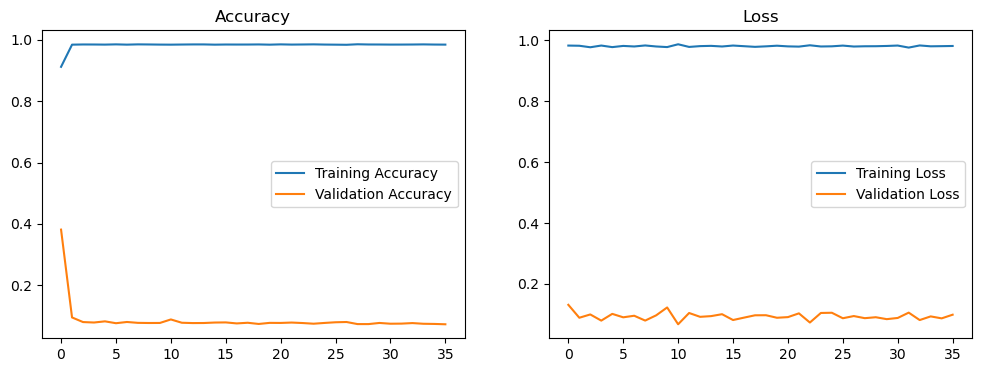

Training time: 39.39 seconds


In [31]:
plot_history(history)
print(f"Training time: {training_time:.2f} seconds")


In [25]:
# Inference on Test Data
def predict_and_plot(test_gen, model, num_samples=3):
    images, masks = next(test_gen)
    predictions = model.predict(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.show()
        

Found 10 validated image filenames.
Found 10 validated image filenames.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


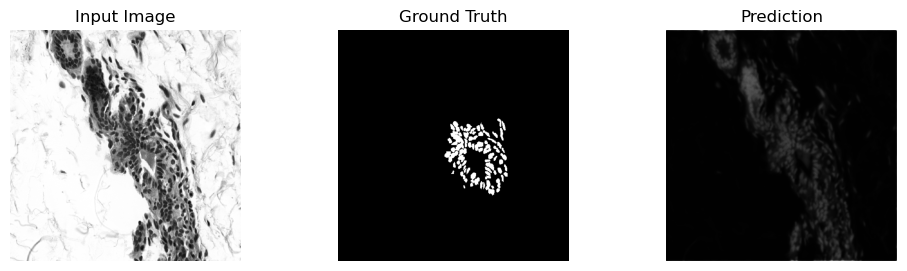

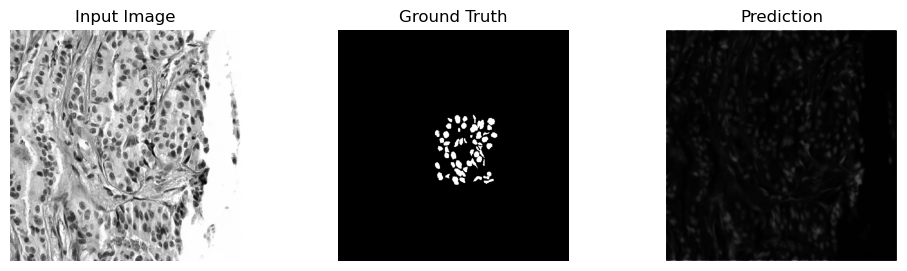

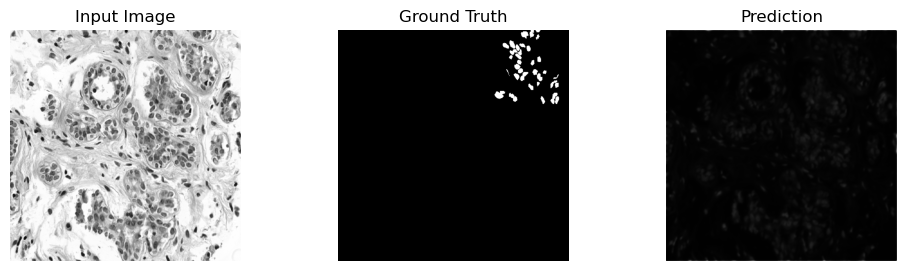

In [33]:
predict_and_plot(test_generator, model)



### Using different loss and metric

In [26]:
# calculate dice coefficient metric

@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


@tf.keras.utils.register_keras_serializable()
# calculate dice loss function
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


@tf.keras.utils.register_keras_serializable()
# calculate bce_dice_loss function
def bce_dice_loss(y_true, y_pred):
    return 0.7 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.3 * dice_loss(y_true, y_pred)


In [32]:
optimizer = optimizers.Adam(learning_rate=1e-3) # keras.optimizers.SGD(learning_rate=0.01, momentum=0.5)
batch_size=3
epochs = 300
loss = bce_dice_loss
metrics = dice_coef


model, history, training_time = train_model()


Epoch 1/300
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - dice_coef: 0.0297 - loss: 0.6604
Epoch 1: val_loss improved from inf to 0.35848, saving model to trained_model/best_unet_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 311ms/step - dice_coef: 0.0290 - loss: 0.6396 - val_dice_coef: 0.0374 - val_loss: 0.3585
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - dice_coef: 0.0235 - loss: 0.3520
Epoch 2: val_loss improved from 0.35848 to 0.35485, saving model to trained_model/best_unet_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - dice_coef: 0.0237 - loss: 0.3519 - val_dice_coef: 0.0264 - val_loss: 0.3549
Epoch 3/300
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - dice_coef: 0.0245 - loss: 0.3462
Epoch 3: val_loss improved from 0.35485 to 0.34844, saving model to trained_model/best_unet_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.0248 - loss: 0.3459 - val_dice_coef: 0.0426 - val_loss: 0.3484
Epoch 4/300
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - dice_coef: 0.0299 - l

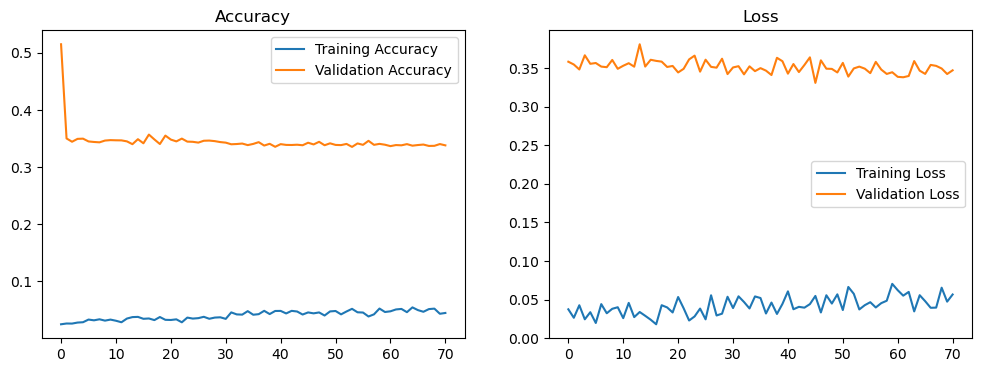

Training time: 37.32 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


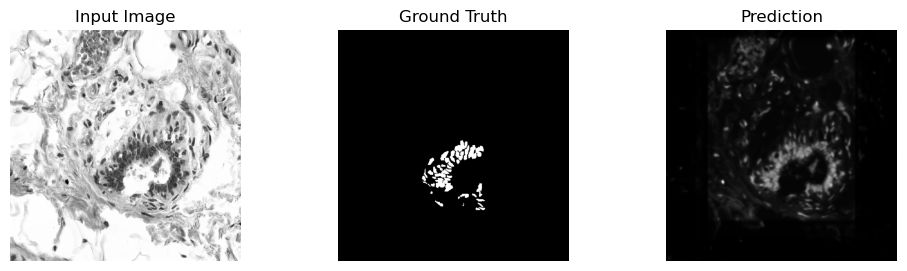

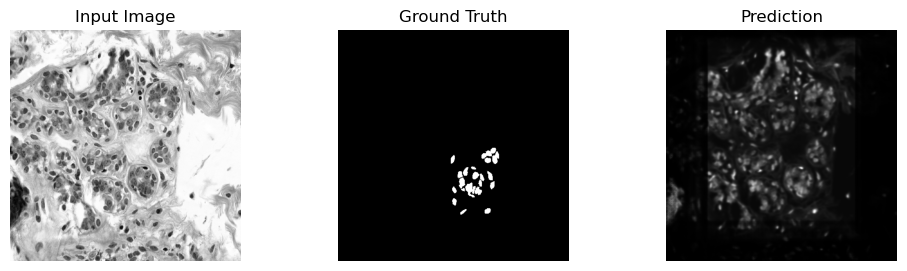

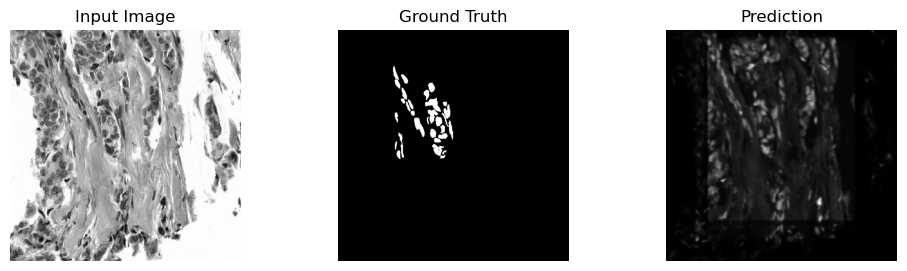

In [33]:
plot_history(history)
print(f"Training time: {training_time:.2f} seconds")
predict_and_plot(test_generator, model)


In [37]:
batch_size = 3
epochs = 300
optimizer = optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss = bce_dice_loss
metrics = dice_coef
file_path = "trained_model/best_unet_model.keras"

model, history, training_time = train_model()


Epoch 1/300
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - dice_coef: 0.0306 - loss: 0.8088
Epoch 1: val_loss improved from inf to 0.62354, saving model to trained_model/best_unet_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - dice_coef: 0.0298 - loss: 0.7980 - val_dice_coef: 0.0367 - val_loss: 0.6235
Epoch 2/300
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.0196 - loss: 0.5708
Epoch 2: val_loss improved from 0.62354 to 0.53918, saving model to trained_model/best_unet_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - dice_coef: 0.0193 - loss: 0.5682 - val_dice_coef: 0.0159 - val_loss: 0.5392
Epoch 3/300
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - dice_coef: 0.0163 - loss: 0.5353
Epoch 3: val_loss improved from 0.53918 to 0.53532, saving model to trained_model/best_unet_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - dice_coef: 0.0167 - loss: 0.5351 - val_dice_coef: 0.0259 - val_loss: 0.5353
Epoch 4/300
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - dice_coef: 0.0233 - 

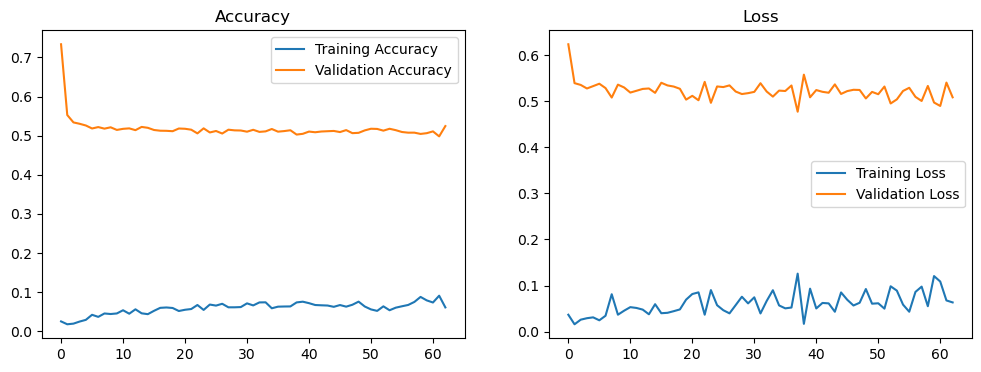

Training time: 44.57 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


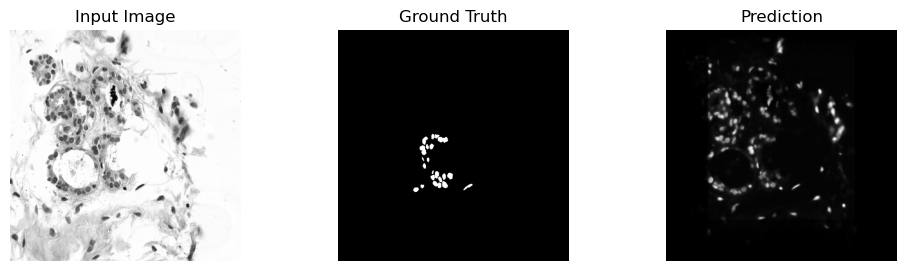

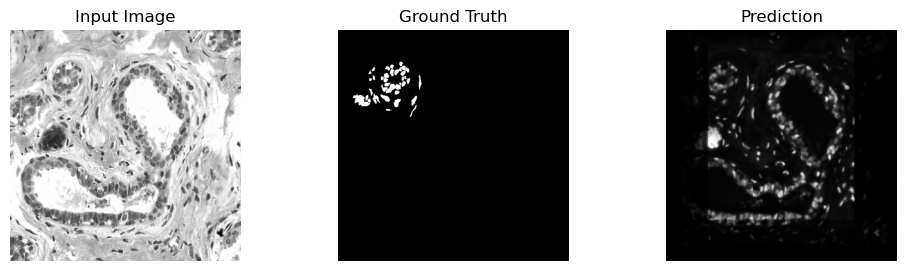

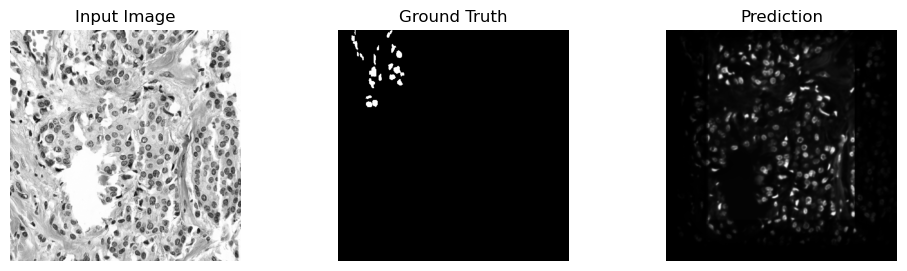

In [38]:
plot_history(history)
print(f"Training time: {training_time:.2f} seconds")
predict_and_plot(test_generator, model)


In [39]:
# load trained model
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
saved_model_path = "trained_model/best_unet_model.keras"
model = load_model(saved_model_path)
print("Model successfully loaded.")

input_shape = (512, 512)
batch_size = 3


Model successfully loaded.


In [41]:
# Evaluate the model
test_steps = len(test_df) // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - dice_coef: 0.1294 - loss: 0.4666
Test Loss: 0.4690
Test Accuracy: 0.1236


### Submitting Slurm Jobs

In [ ]:
### Example training script: train_model.py

import os
import argparse
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import tensorflow.keras.optimizers as optimizers
from losses import *
from unet import unet
from unet_3plus import UNet_3Plus, UNet_3Plus_DeepSup, UNet_3Plus_DeepSup_CGM
from dataloaders import get_train_generator
from utils import load_history_file

from neptune_config import config_run


def get_args():
    parser = argparse.ArgumentParser(description='Train the model on images and masks')
    parser.add_argument('--num-epochs', '-e', dest='epochs', type=int, default=5, help='Number of epochs')
    parser.add_argument('--batch-size', '-b', dest='batch_size', type=int, default=1, help='Batch size')
    parser.add_argument('--learning-rate', '-l', dest='lr', type=float, default=0.01, help='Learning rate')
    parser.add_argument('--optimizer', '-o', dest='optimizer', default='sgd',
                        help='Optimizer type: adam or sgd')

    parser.add_argument('--model-path', '-p', dest='model_path', type=str, default='../trained_models',
                        help='Path to save the trained model')
    parser.add_argument('--model-name', '-n', dest='model_name', type=str, required=True,
                        help='Name of the trained model to be saved')
    
    parser.add_argument('--train-data', '-d', dest='train_data', type=str, default='../dataset/train_df.pkl',
                        help='File name of the dataframe that contains train image paths')
    parser.add_argument('--val-data', '-f', dest='val_data', type=str, default='../dataset/val_df.pkl',
                        help='File name of the dataframe that contains train image paths')
    
    return parser.parse_args()


def get_hyperparameter():
    args = get_args()    
    # Define paramaters for train generator
    target_size = (256,256)
    seed = 1
    input_shape = [256, 256, 1]
    output_channels = 1
    
    params = {
        "batch_size": args.batch_size,
        "train_size": target_size,
        "learning_rate": args.lr,
        "optimizer": args.optimizer,
        "loss": "BCE Dice",
        #"metrics": [dice_coef],
    }

    return args, target_size, seed, params, input_shape, output_channels

    
def train_model():
    args, target_size, seed, params, input_shape, output_channels = get_hyperparameter()

    run = config_run()
    run["parameters"] = params
    run["sys/name"] = args.model_name
    run["sys/unet_type"] = args.unet_type

    # Load train_df
    df1 = pd.read_pickle(args.train_data)
    df2 = pd.read_pickle(args.val_data)
    train_df = pd.concat([df1, df2], ignore_index=True, axis=0)
    
    # Create data generator for training set with data augmentation
    train_generator, train_step_size = get_train_generator(train_df, args.batch_size, target_size)
    
    # Load U-net model
    model = unet()
    
    # Complile the model
    if args.optimizer == 'adam':
        model.compile(optimizer=optimizers.Adam(learning_rate=args.lr), loss=bce_dice_loss, metrics = [dice_coef])
        #model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy']) # s16_2
    else:
        model.compile(optimizer=optimizers.SGD(learning_rate=args.lr, momentum=0.90, decay=1e-6), loss=bce_dice_loss, metrics = [dice_coef])

    # Train the model
    model_file = os.path.join(args.model_path, args.model_name + ".hdf5")
    model_checkpoint = ModelCheckpoint(model_file, monitor='loss',verbose=1, save_best_only=True)
    history = model.fit(train_generator, steps_per_epoch=train_step_size, epochs=args.epochs, callbacks=[model_checkpoint])
    #run["loss"].log(history.history)

    # Save model history
    history_file_name = os.path.join(args.model_path, args.model_name + "_history.npy")
    np.save(history_file_name, history.history)
    losses, accuracy = load_history_file(history_file_name, args.unet_type, run)
    
    # log accuracy and losses
    for i in range(len(losses)):
        print("Epoch: ",i+1, ", loss: ", losses[i], ", accuracy: ", accuracy[i])
        if run is not None:
            run["train/loss"].append(losses[i]) # change .log to .append
            run["train/accuracy"].append(accuracy[i])

    # with early stopping
    es = EarlyStopping(monitor='loss', mode='min', verbose=1)
    history = model.fit(train_generator,steps_per_epoch=train_step_size,epochs=20,callbacks=[es])
    model.save(model_file_location)

    run.stop()



if __name__ == '__main__':
    train_model()

In [ ]:
# Example slurm script: train.sbatch
'''
#!/bin/bash

#SBATCH --job-name=unet_breast_cancer
#SBATCH -p a100-4     
#SBATCH --gres=gpu:a100:4
#SBATCH --mem-per-cpu=10g
#SBATCH -c 8
#SBATCH --time=5:00:00
#SBATCH --mail-user=mo000007@umn.edu
#SBATCH -o output/unet_%j.output
##SBATCH -e output/unet_%j.error

source activate tf-gpu
python train_model.py --num-epochs 2000 --batch-size 10 
--learning-rate 0.01 --optimizer 'adam' --model-name 'unetv2'

'''


'''
To submit slurm job: sbatch scriptname 
                     eg. sbatch train.sbatch
                     
To view slurm job:   sbatch -p partitionname scriptname 
To cancel slurm job: scancel jobIDnumber 

'''

### Tracking experiments

#### TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

#### https://www.tensorflow.org/tensorboard/get_started


In [35]:
# adding tensorboard

%load_ext tensorboard
from tensorflow.keras.callbacks import TensorBoard
import datetime

mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28, 28), name='layers_input'),
    tf.keras.layers.Flatten(name='layers_flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='layers_dense'),
    tf.keras.layers.Dropout(0.2, name='layers_dropout'),
    tf.keras.layers.Dense(10, activation='softmax', name='layers_dense_2')
  ])


model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8892 - loss: 0.3677 - val_accuracy: 0.9645 - val_loss: 0.1185
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 813us/step - accuracy: 0.9700 - loss: 0.1005 - val_accuracy: 0.9727 - val_loss: 0.0871
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9787 - loss: 0.0698 - val_accuracy: 0.9787 - val_loss: 0.0715
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.9848 - loss: 0.0493 - val_accuracy: 0.9781 - val_loss: 0.0745
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.9874 - loss: 0.0401 - val_accuracy: 0.9825 - val_loss: 0.0621


### More on Tensorboard: https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/get_started.ipynb

References

https://www.kaggle.com/datasets/andrewmvd/breast-cancer-cell-segmentation/data

https://www.tensorflow.org/

https://github.com/Nguyendat-bit/U-net